# A Speed Comparison Of C, Julia, Python, Numba, and Cython on LU Factorization

## [Jean-François Puget](https://www.ibm.com/developerworks/community/blogs/jfp?lang=en)

The code in this notebook has been used to generate the results discussed in [A Speed Comparison Of C, Julia, Python, Numba, and Cython on LU Factorization](https://www.ibm.com/developerworks/community/blogs/jfp/entry/a_comparison_of_c_julia_python_numba_cython_scipy_and_blas_on_lu_factorization)


This study was inspired by Sebastian F. Walter's [Speed comparision Numba vs C vs pure Python at the example of the LU factorization](http://expdesign.iwr.uni-heidelberg.de/people/swalter/blog/python_numba/index.html)

Timingsheavily depend on the machine you use.

We start with an import of useful packages.

In [1]:
import numpy as np
import pandas as pd
import time
from numpy.testing import *
from scipy.linalg import *

import gc
from matplotlib import pyplot as plt
%matplotlib inline

from numba import njit, void, double

### Pure Python

In [2]:
def det_by_lu(y, x):
    y[0] = 1.

    N = x.shape[0]
    for k in range(N):
        y[0] *= x[k,k]
        for i in range(k+1, N):
            x[i,k] /= x[k,k]
            for j in range(k+1, N):
                x[i,j] -= x[i,k] * x[k,j]

In [3]:
def run_python(A,B,y,N):

    # check that result is correct
    np.copyto(B,A)
    det_by_lu(y, B)

    L = np.tril(B, -1) + np.eye(N)
    U = np.triu(B)
    assert_almost_equal( L.dot(U),  A)
    
    gc.disable()
    st = time.time()
    
    loops = 1 + (100000 // (N*N))
    
    for l in range(loops):
        np.copyto(B,A)
        det_by_lu(y, B)
        
    et = time.time()
    gc.enable()
    
    return  (et - st)/loops

### Numpy

In [4]:
def numpy_det_by_lu(y, x):
    y[0] = 1.

    N = x.shape[0]
    with np.errstate(invalid='ignore'):
        for k in range(N):
            y[0] *= x[k,k]
            xk = x[k]
            for i in range(k+1, N):
                xi = x[i]
                xi[k] /= xk[k]
                xi[k+1:] -= xi[k] * xk[k+1:]

In [5]:
def run_numpy(A,B,y,N):

    # check that result is correct
    np.copyto(B,A)
    numpy_det_by_lu(y, B)

    L = np.tril(B, -1) + np.eye(N)
    U = np.triu(B)
    assert_almost_equal( L.dot(U),  A)
    
    gc.disable()
    st = time.time()
    
    loops = 1 + (100000 // (N*N))
    
    for l in range(loops):
        np.copyto(B,A)
        numpy_det_by_lu(y, B)
        
    et = time.time()
    gc.enable()
    
    return  (et - st)/loops

### Numba

In [6]:
def numba_det_by_lu(y, x):
    y[0] = 1.

    N = x.shape[0]
    for k in range(N):
        y[0] *= x[k,k]
        for i in range(k+1, N):
            x[i,k] /= x[k,k]
            for j in range(k+1, N):
                x[i,j] -= x[i,k] * x[k,j]
            

fastdet_by_lu = njit(void(double[:], double[:,:]))(numba_det_by_lu)

In [7]:
def run_numba(A,B,y,N):

    # check that result is correct
    np.copyto(B,A)
    fastdet_by_lu(y, B)

    L = np.tril(B, -1) + np.eye(N)
    U = np.triu(B)
    assert_almost_equal( L.dot(U),  A)
    
    gc.disable()
    st = time.time()
    
    loops = 1 + min(1000000 // (N*N), 20000)
    
    for l in range(loops):
        np.copyto(B,A)
        fastdet_by_lu(y, B)
        
    et = time.time()
    gc.enable()
    
    return  (et - st)/loops

### Cython

In [8]:
%load_ext cython

In [9]:
%%cython --verbose --compile-args=-march=native --compile-args=-ffast-math

import cython

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef cython_det_by_lu(double[:] y, double[:,:] x):
    y[0] = 1.

    cdef int N = x.shape[0]
    cdef int i,j,k
    
    for k in range(N):
        y[0] *= x[k,k]
        for i in range(k+1, N):
            x[i,k] /= x[k,k]
            for j in range(k+1, N):
                x[i,j] -= x[i,k] * x[k,j]

In [10]:
def run_cython(A,B,y,N):

    # check that result is correct
    np.copyto(B,A)
    cython_det_by_lu(y, B)

    L = np.tril(B, -1) + np.eye(N)
    U = np.triu(B)
    assert_almost_equal( L.dot(U),  A)
    
    gc.disable()
    st = time.time()
    
    loops = 1 + min(1000000 // (N*N), 20000)
    for l in range(loops):
        np.copyto(B,A)
        cython_det_by_lu(y, B)
        
    et = time.time()
    gc.enable()
    
    return  (et - st)/loops

### C

In [11]:
!gcc -shared -O3 -march=native -ffast-math lu.c -o lu.so

In [12]:
from cffi import FFI
ffi = FFI()
ffi.cdef('void det_by_lu(double *y, double *B, int N);')
C = ffi.dlopen("lu.so")
c_det_by_lu = C.det_by_lu

In [13]:
def run_c(A,B,y,N):
    # run c code
    #B = numpy.zeros((N,N), order='F')
    #B[:,:] = A
    np.copyto(B,A)
    c_det_by_lu(ffi.cast("double *", y.ctypes.data),
                ffi.cast("double *", B.ctypes.data),
                ffi.cast("int", N))
    
    # check that result is correct
    L = np.tril(B, -1) + np.eye(N)
    U = np.triu(B)
    assert_almost_equal( L.dot(U),  A)
    
    gc.disable()
    st = time.time()
    
    loops = 1 + min(1000000 // (N*N), 20000)
    
    for l in range(loops):
        np.copyto(B,A)
        c_det_by_lu(ffi.cast("double *", y.ctypes.data),
                    ffi.cast("double *", B.ctypes.data),
                    ffi.cast("int", N))
        
    et = time.time()
    gc.enable()
    
    return  (et - st)/loops


### Scipy 

In [14]:
def run_scipy(A,B,y,N):

    # check that result is correct
    np.copyto(B,A)
    (P,L,U) = lu(B,overwrite_a=True)

    assert_almost_equal( P.dot(L.dot(U)),  A)
    
    gc.disable()
    st = time.time()
    
    loops = 1 + min(1000000 // (N*N), 20000)

    for l in range(loops):
        np.copyto(B,A)
        lu(B,overwrite_a=True)
        
    et = time.time()
    gc.enable()
    
    return  (et - st)/loops

### Lapack

In [15]:
def run_lapack(A,B,y,N):

    # check that result is correct
    
    gc.disable()
    st = time.time()
    
    loops = 1 + min(1000000 // (N*N), 20000)

    for l in range(loops):
        np.copyto(B,A)
        lu_factor(B,overwrite_a=True)
        
    et = time.time()
    gc.enable()
    
    return  (et - st)/loops

### Timings

In [16]:
def timings(n=7, \
            series=['pure python', 'c', 'numba', 'numpy', \
                    'cython', 'scipy', 'lapack', 'julia']):
    
    Ns = np.array([5,10,30,100, 200, 300, 400, 600, 1000, 2000, 4000, 8000])
    Fs = [run_python, run_c, run_numba, run_numpy, \
          run_cython, run_scipy, run_lapack]
    times = pd.DataFrame(np.zeros((n, len(Fs)+1)), index = Ns[:n], columns = series)
    for i,N in enumerate(Ns[:n]):
        print ('N =', N, end=" ")
        A = np.random.random((N,N))
        B = np.empty(A.shape)
        y = np.zeros(1)
        for j,label in enumerate(series[:-1]):
            if label != '': 
                print(j, end=" ")
                times.loc[N,label] = Fs[j](A,B,y,N)
        print('')
    return times


### Running the code

In [17]:
times = timings()

N = 5 0 1 2 3 4 5 6 
N = 10 0 1 2 3 4 5 6 
N = 30 0 1 2 3 4 5 6 
N = 100 0 1 2 3 4 5 6 
N = 200 0 1 2 3 4 5 6 
N = 300 0 1 2 3 4 5 6 
N = 400 0 1 2 3 4 5 6 


### Checking results

In [18]:
times

,pure python,c,numba,numpy,cython,scipy,lapack,julia
5,0.000049,0.000007,0.000001,0.000073,0.000002,0.000021,0.000010,0.0
10,0.000346,0.000008,0.000002,0.000244,0.000003,0.000034,0.000015,0.0
30,0.009136,0.000012,0.000014,0.002091,0.000013,0.000125,0.000119,0.0
100,0.339253,0.000115,0.000474,0.024193,0.000322,0.001314,0.001409,0.0
200,2.635658,0.001274,0.005524,0.113465,0.004296,0.004359,0.004316,0.0
300,8.999600,0.004218,0.016508,0.252939,0.012162,0.007852,0.006186,0.0
400,20.884147,0.010094,0.036438,0.460263,0.026233,0.011604,0.008870,0.0


### Adding Julia timings.

Here is the output of the julia code

In [19]:
!julia lu.jl

400000//1
  0.358769 seconds (673.09 k allocations: 35.185 MiB)
400000//1
100000//1
100000//9
1000//1
250//1
1000//9
125//2
250//9
10//1

time per loop=
[1.75764045e-7, 6.4414374e-7, 1.270633365e-5, 0.00042416499000000004, 0.003296228324, 0.010970920214999999, 0.02566115192, 0.08423355495599999, 0.3971115121]

In [20]:
julia_times = [1.75764045e-7, 6.4414374e-7, 1.270633365e-5, 0.00042416499000000004, 0.003296228324, 0.010970920214999999, 0.02566115192, 0.08423355495599999, 0.3971115121]

We add these into our timings data frame

In [21]:
M = min(len(julia_times),times.shape[0])
times['julia'] = julia_times[:M]

Checking results again

In [22]:
times

,pure python,c,numba,numpy,cython,scipy,lapack,julia
5,0.000049,0.000007,0.000001,0.000073,0.000002,0.000021,0.000010,1.757640e-07
10,0.000346,0.000008,0.000002,0.000244,0.000003,0.000034,0.000015,6.441437e-07
30,0.009136,0.000012,0.000014,0.002091,0.000013,0.000125,0.000119,1.270633e-05
100,0.339253,0.000115,0.000474,0.024193,0.000322,0.001314,0.001409,4.241650e-04
200,2.635658,0.001274,0.005524,0.113465,0.004296,0.004359,0.004316,3.296228e-03
300,8.999600,0.004218,0.016508,0.252939,0.012162,0.007852,0.006186,1.097092e-02
400,20.884147,0.010094,0.036438,0.460263,0.026233,0.011604,0.008870,2.566115e-02


### Display

In [29]:
def plot_times(times, 
               cols = [],\
               name="runtimes.png"):
    plt.figure(figsize=(10,6))
    if cols == []:
        cols = times.columns
    for i,label in enumerate(cols):
        if label != '':
            plt.loglog(times.index, times[label], label=label)
    plt.xlabel("N (matrix size)")
    plt.ylabel("runtime [sec]")
    plt.grid()
    plt.legend(loc=2)
    plt.savefig(name)
    plt.show()

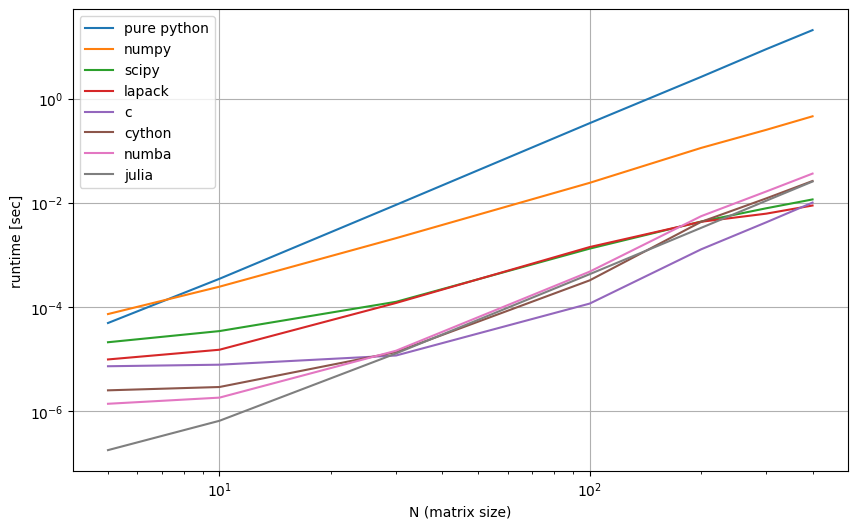

In [35]:
plot_times(times, cols=['pure python', 'numpy', 'scipy', 'lapack', 'c', 'cython',  'numba', 'julia'], name='runtimes_1')

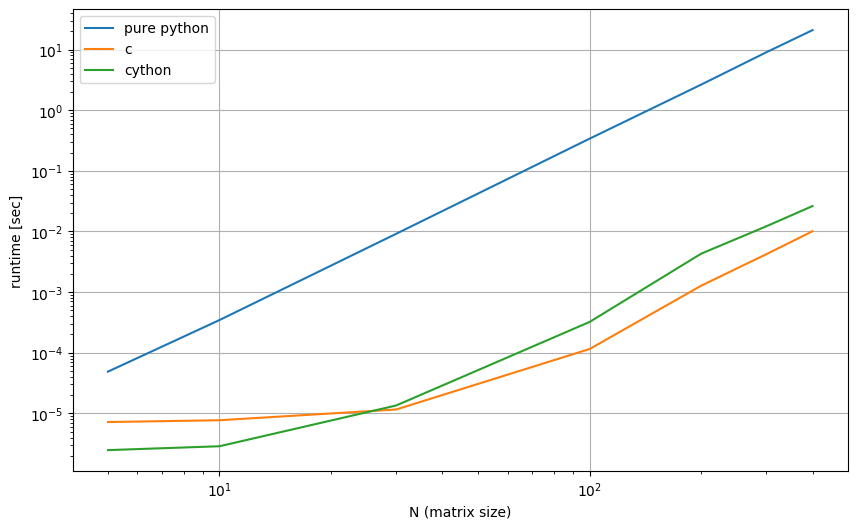

In [31]:
plot_times(times, cols=['pure python', 'c', 'cython'], name='runtimes_2')

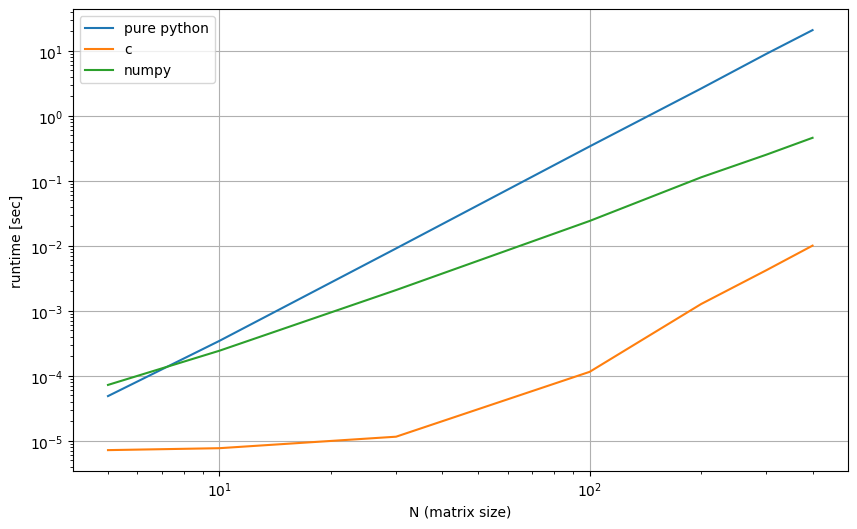

In [32]:
plot_times(times, cols=['pure python', 'c', 'numpy'], name='runtimes_3')

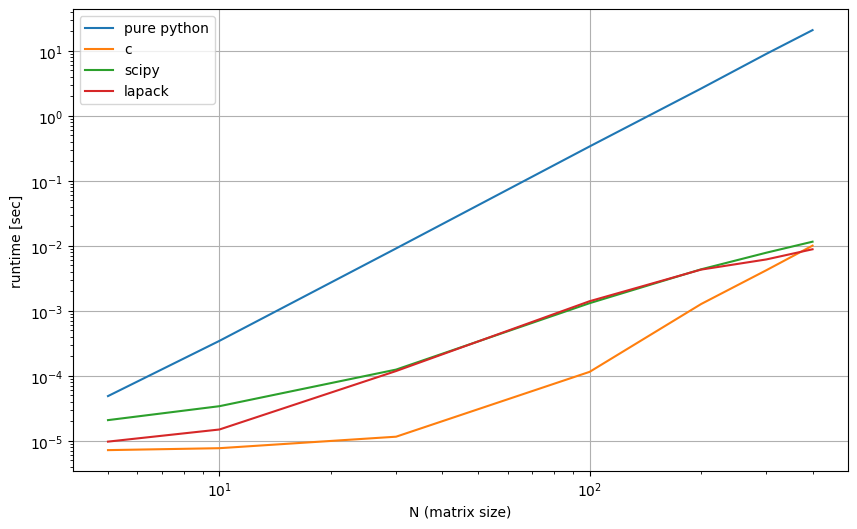

In [33]:
plot_times(times, cols=['pure python', 'c', 'scipy', 'lapack'], name='runtimes_4')

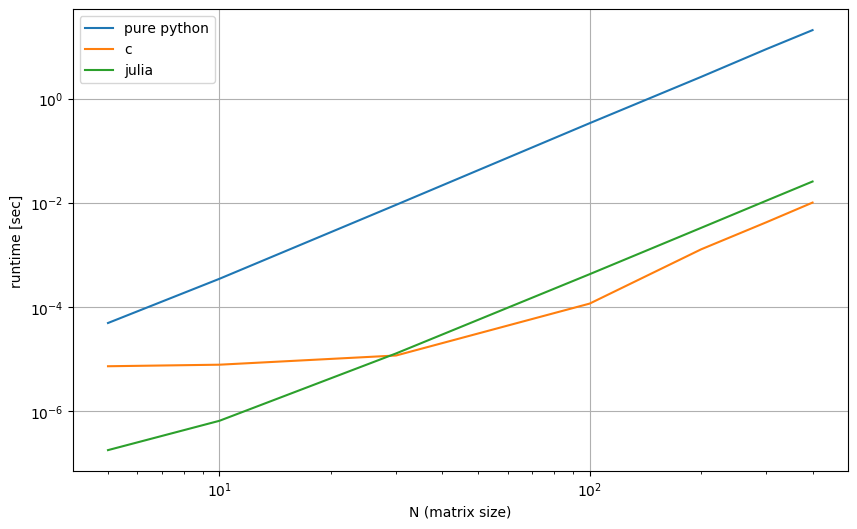

In [34]:
plot_times(times, cols=['pure python', 'c', 'julia'], name='runtimes_5')